# Machine Learning Engineer Nanodegree

## Capstone Project

### Predicting Online News Article Popularity

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os

#for reproducibility in keras
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#suppress the future deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import DMatrix

from IPython.display import display

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

from metrics import MetricsCallback

DATA_PATH = "./data/"
DATA_FILE = "OnlineNewsPopularity.csv"
HI_SHARES_COL = "high_shares"
CHKPT_DIR = "./chkpt/"


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def histograms(df, col):
    popular = df[df[HI_SHARES_COL] == 1][col]
    unpopular = df[df[HI_SHARES_COL] == 0][col]
    return popular, unpopular


# plot a 2X2 set of dual histograms, i.e., historgrams that have two distributions superimposed,
# one for popular articles, and one for unpopular articles. So each image will have 4 histograms.
# This function will be called in a loop so that we can get histograms for all 58 predictive
# features.
def plot_hist(x, y, rng):
    plt.figure(figsize=(9, 4.9))
    for num, col_name in enumerate(x.columns[rng]):
        plt.subplot(2, 2, num + 1)
        plt.hist((histograms(x.join(y), col_name)[0], histograms(x.join(y), col_name)[1]),
                  bins=50, alpha=0.4, label=['popular', 'unpopular'], color=['red', 'blue'])
        plt.legend()
        plt.title(col_name)
    plt.tight_layout()


def printout(name, data_type, y, y_pred):
    print(name, "Accuracy score on the", data_type, "data: {:.4f}".format(accuracy_score(y, y_pred)))
    print(name, "Precision score on the", data_type, "data: {:.4f}".format(precision_score(y, y_pred)))
    print(name, "Recall score on the", data_type, "data: {:.4f}".format(recall_score(y, y_pred)))
    print(name, "F1 score on the", data_type, "data: {:.4f}".format(f1_score(y, y_pred)))
    print(name, "AUC of ROC on the", data_type, "data: {:.4f}".format(roc_auc_score(y, y_pred)))
    print('\n')
    

def classifier_score(clf, name, x, y, data_type="validation"):
    y_pred = clf.predict(x)
    printout(name, data_type, y, y_pred)


#return a basic neural net model for use as a default for comparison
def basic_neural_net():
    num_classes = 2
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=58))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


def fit_nn(model, X_train, y_train, X_val, y_val):
    filepath = CHKPT_DIR + "chkpt-{epoch:02d}.hdf5"
    chkpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=10, save_best_only=False, mode='max')
    metrics_callback = MetricsCallback(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    callbacks = [chkpt, metrics_callback]
    model.fit(X_train, y_train.ravel(),
              batch_size=32,
              epochs=300,
              validation_data=(X_val, y_val.ravel()),
              verbose=10,
              callbacks=callbacks)
    return model, callbacks
    

# print out the scores of the nn, based on the best epoch achieved during training
def print_scores(model, callbacks, x, y, loss_func="binary_crossentropy", optimizer="adam", data_type="test"):
    best_epoch = callbacks[1].best_epoch
    filename = CHKPT_DIR + "chkpt-" + str(best_epoch) + ".hdf5"
    model.load_weights(filename)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    print("Created model and loaded weights from file " + filename)
    y_pred_test = model.predict_classes(x)
    printout("", data_type, y, y_pred_test)
    

# run GridSearch on a classifier
def gridsearch(clf, parameters, X_train, y_train, X_val, y_val):    
    scorer = make_scorer(score_func=roc_auc_score)
    grid_obj = GridSearchCV(estimator=clf, scoring=scorer, param_grid=parameters, verbose=10)
    grid_obj.fit(X_train, y_train)

    results = pd.DataFrame(grid_obj.cv_results_)
    results = results.sort_values(by='mean_test_score', ascending=False)
    best_clf = grid_obj.best_estimator_
    y_pred = best_clf.predict(X_val)

    print("\nOptimized Model\n------")
    printout("Optimized Model", "validation", y_val, y_pred)
    return best_clf, results


# Split an array into groups with equal numbers of elements.
# Last group may have smaller number of elements
def splitter(arr, group):
    return (arr[pos:pos + group] for pos in range(0, len(arr), group))


## Data Exploration

Begin by loading the data. Some of the column headings have extra spaces that need to be trimmed. I'll also drop the <code>url</code> column since it is non-predictive, though useful when cross-referencing the data with the actual content of the Mashable articles.

In [3]:
all_data = pd.read_csv(DATA_PATH + DATA_FILE)
#remove spaces from feature names
all_data.rename(columns=lambda x: x.replace(" ", ""), inplace=True)
#drop 'url' column since it is non-predictive
all_data = all_data.drop(labels=["url"], axis=1)

In [4]:
print("all_data rows:", all_data.shape[0])
print("all_data columns:", all_data.shape[1])

all_data rows: 39644
all_data columns: 60


### Check for null values

Fortunately there are none.

In [5]:
all_data.isnull().sum()

timedelta                        0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
kw_max_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_max_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
kw_avg_avg                       0
self_reference_min_shares        0
self_reference_max_s

### Check for bad data

There is a significant problem with erroneous data. I did not do a thorough analysis of all rows, but without much effort I was able to identify bad data that amounted to about <b>3%</b> of the dataset. With more effort, I feel confident that more bad data would be discovered.

In the code below, I am removing 1,181 rows which have a value of 0 in the feature <code>n_tokens_content</code>. These rows also have 0 in a number of other features that logically should not be 0. I am also removing one row which has values greater than 1.0 for the features which are rates (e.g., <code>n_unique_tokens</code>, <code>n_non_stop_words</code>) and should therefore be under 1.0.

In addition to the bad rows which I deleted, there were other inconsistencies. The <code>num_imgs</code> and <code>num_videos</code> features were not accurate on any of the 10 or so articles that I sampled. 

I also found inaccuracies in the <code>self_reference_min_shares</code>, <code>self_reference_max_shares</code>, and <code>self_reference_avg_shares</code>. For example, for article <a href="http://mashable.com/2013/07/21/gaymerx/">GaymerX: World's First LGBT Gamer Convention Comes to San Francisco</a> the value for each of these three features is 843,300. Thus one would expect to find in this article a link to a very popular Mashable article which has 843,300 shares. There is only one such article in the dataset with that many shares, and there is no link to it in the GaymerX article. Similarly, the article <a href="http://mashable.com/2013/07/12/sprint-unlimited-data-for-life/">Sprint's New Plans Guarantee Unlimited Data for Life</a> garnered 210,300 shares. It was the only article with that share count in the dataset. The article titled <a href="http://mashable.com/2013/07/23/spike-lee-kickstarter/">Spike Lee Wants Kickstarter's Help for His 'Newest, Hottest Joint'</a> has 210,300 for the value in the three related features listed above. But there is no reference in the Spike Lee article to the Sprint Unlimited Data article.

The errors revealed in this small sampling lead me to believe that the data are flawed and not reliable. There are likely other problems in addition to those listed above. Nevertheless, I will proceed with the project using the given dataset (minus the rows I am deleting below). This amounts to merely an academic exercise, unfortunately, as any conclusions will be just as flawed as the dataset.

In [6]:
no_content = all_data.loc[all_data['n_tokens_content'] == 0.0]
bad_rate = all_data.loc[all_data['n_unique_tokens'] > 1.0]

num_no_content = int(no_content.shape[0])
num_bad_rate = int(bad_rate.shape[0])
print("articles with 0 content:", num_no_content)
print("samples with rates > 0:", num_bad_rate)
print("percentage of bad rows in original data:", "{:.2%}".format((num_no_content + num_bad_rate) / int(all_data.shape[0])))

# remove data with rates > 0
all_data = all_data[all_data.n_unique_tokens < 1.0]
# remove data with 0 content
all_data = all_data[all_data.n_tokens_content != 0.0]
print("all_data rows:", all_data.shape[0])
print("all_data cols:", all_data.shape[1])

articles with 0 content: 1181
samples with rates > 0: 1
percentage of bad rows in original data: 2.98%
all_data rows: 38462
all_data cols: 60


In [7]:
# first 5 rows of data
pd.options.display.max_columns = None
display(all_data.head())

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


#### Sample of data with no content

Notice that <code>n_tokens_content</code>, <code>n_unique_tokens</code>, <code>n_non_stop_words</code>, etc all have a value of 0.0 which should not happen, so I removed these rows.

In [8]:
# No Content Data
display(no_content.head())

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
893,715.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,217.0,1200.0,542.500000,0.0,51900.0,16928.571429,0.0,3647.272727,1923.430603,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.191383,0.028703,0.179282,0.572047,0.028586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550000,-0.500000,0.050000,0.500000,2500
917,715.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,217.0,2000.0,582.285714,0.0,51900.0,16080.000000,0.0,2939.239130,1596.149445,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.020362,0.133522,0.020019,0.020554,0.805543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,1700
1062,713.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,217.0,2500.0,669.000000,0.0,51900.0,17255.555556,0.0,4380.000000,2328.023284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.532843,0.022387,0.260606,0.023187,0.160977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,4500
1121,712.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,217.0,1700.0,611.000000,0.0,51900.0,13628.571429,0.0,4408.000000,2332.097082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.885229,0.028718,0.028587,0.028866,0.028599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.033333,0.433333,0.033333,6800
1312,709.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,217.0,1700.0,517.800000,440.0,51900.0,17628.000000,440.0,4423.333333,2305.412167,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020977,0.020356,0.020075,0.918569,0.020023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283333,0.266667,0.216667,0.266667,1000


#### Data with rates > 1.0

Notice that <code>n_unique_tokens</code>, <code>n_non_stop_words</code>, <code>n_non_stop_unique_tokens</code> > 1.0 which should never happen so I removed this row.

In [9]:
# Bad Rate Data
display(bad_rate.head())

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
31037,142.0,9.0,1570.0,701.0,1042.0,650.0,11.0,10.0,51.0,0.0,4.696178,7.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,778.0,143.714286,23100.0,843300.0,330442.857143,2420.579189,3490.598812,2912.105124,795.0,0.0,6924.375,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5900


## Exploratory Visualization

### Defining popularity

To decide how to divide up the popular articles from unpopular, I'll look at the breakdown of shares vs. the median.

In [10]:
print("shares > median =", all_data[all_data['shares'] > np.median(all_data.shares)].shape[0])
print("shares < median =", all_data[all_data['shares'] < np.median(all_data.shares)].shape[0])
print("shares == median =", all_data[all_data['shares'] == np.median(all_data.shares)].shape[0])

shares > median = 18911
shares < median = 17999
shares == median = 1552


The most equitable split will be:

<code>popular > median
unpopular <= median</code>

### Create target

Next I'll move the target column (<code>high_shares</code>) to y.

In [11]:
X_df = all_data.copy()
X_df[HI_SHARES_COL] = (X_df.shares - np.median(X_df.shares) > 0).astype('int32')
# we can drop the timedelta column because it is non-predictive
X_df = X_df.drop(labels=["timedelta", "shares"], axis=1)
# create a y dataframe that consists of the HI_SHARES_COL, then drop that column from all_data
y = pd.DataFrame(X_df[HI_SHARES_COL], columns=[HI_SHARES_COL])
X_df = X_df.drop(labels=[HI_SHARES_COL], axis=1)

### Histogram Analysis

Now that we've divided up the data between the predictive features and the target, we can do a histogram analysis. Below is a series of superimposed histograms, one for each of the features. The red histogram is the distribution of popular articles (articles with > median shares), and the blue histogram is the distribution of unpopular articles (articles with <= median shares). Where there is skewing of the red and the blue distributions, there is the potential for a classifier to discover predictability.

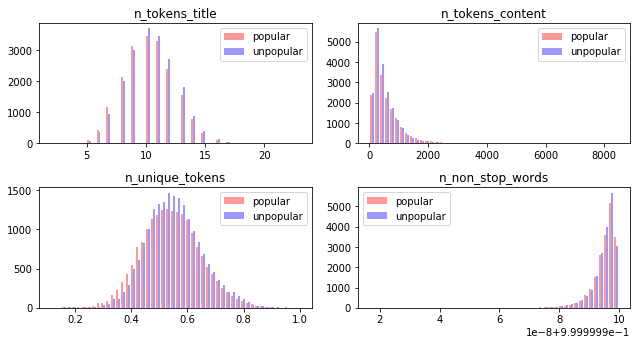

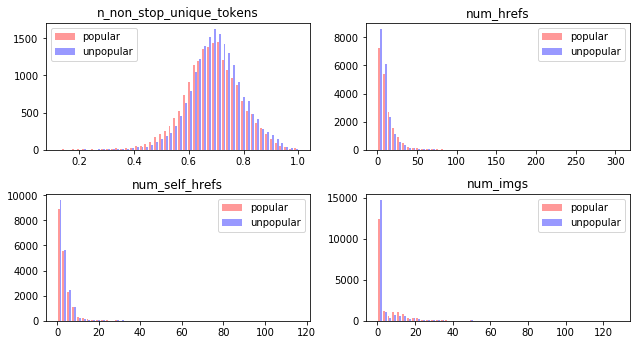

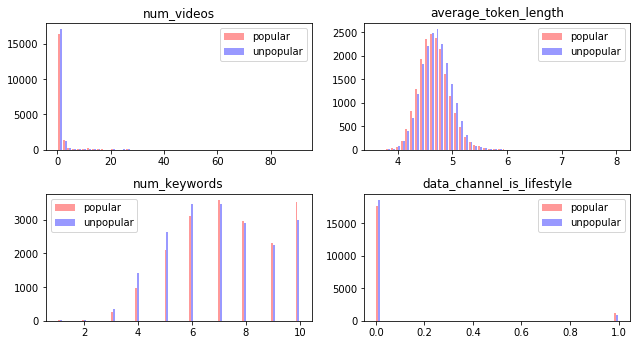

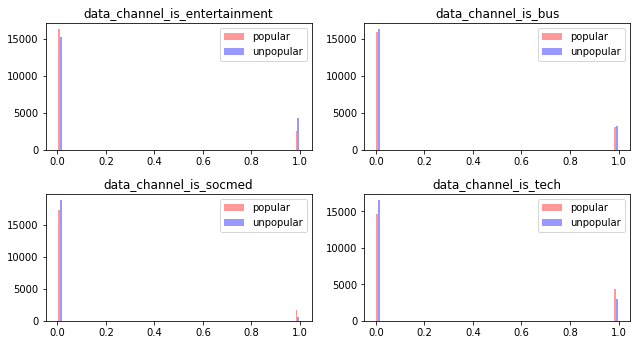

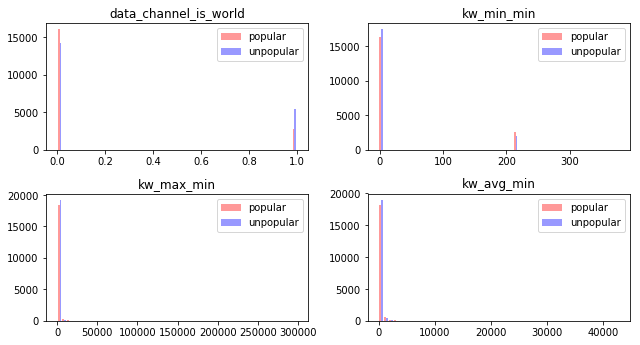

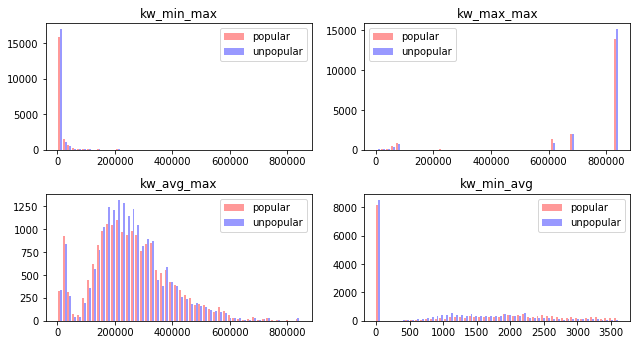

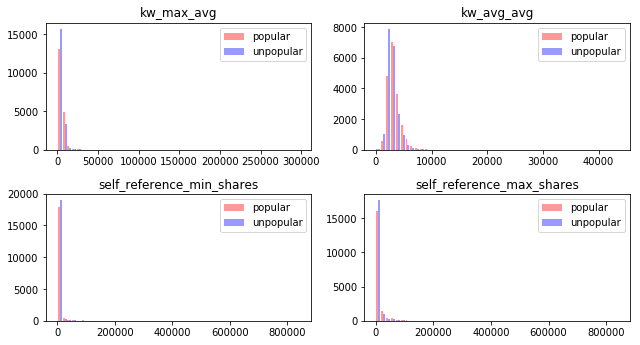

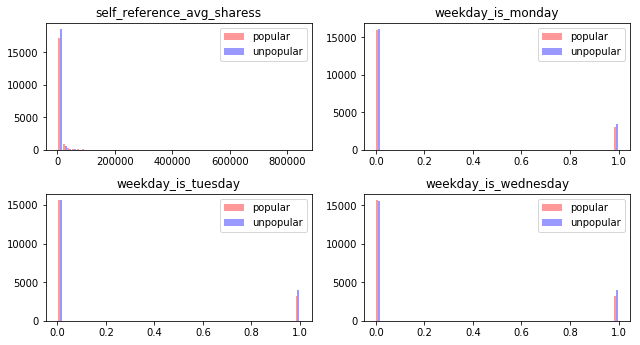

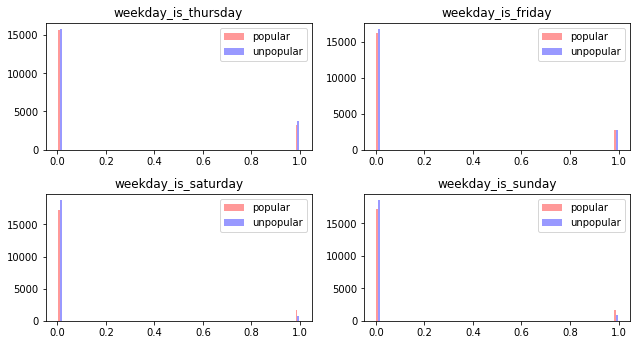

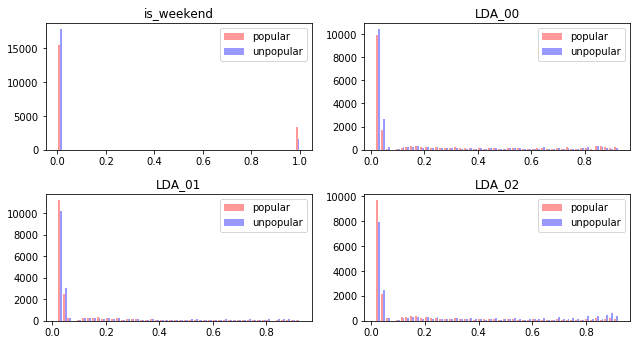

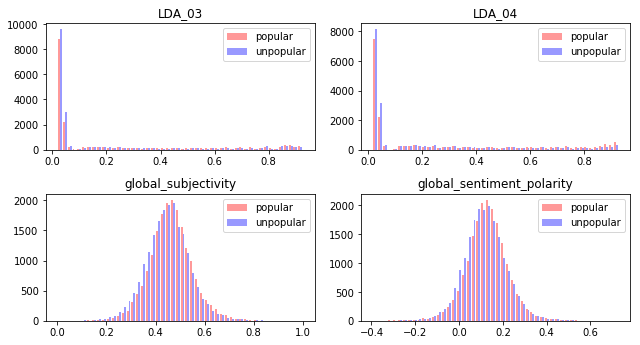

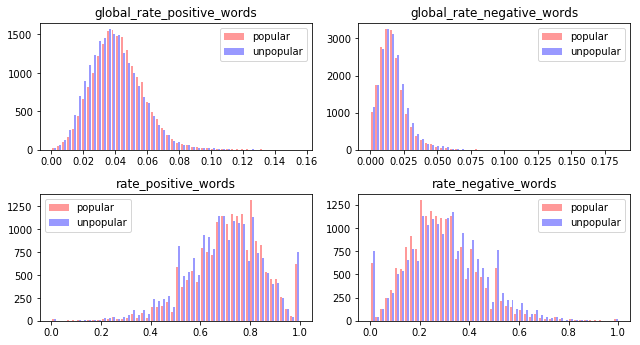

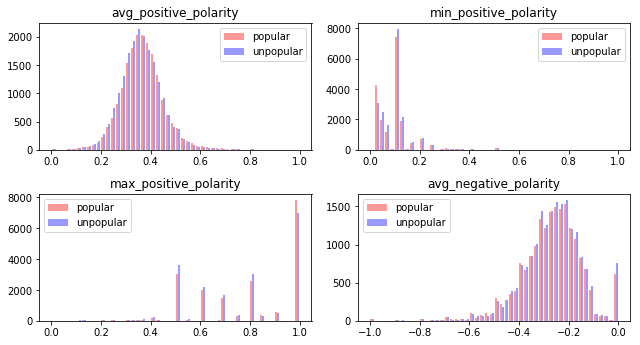

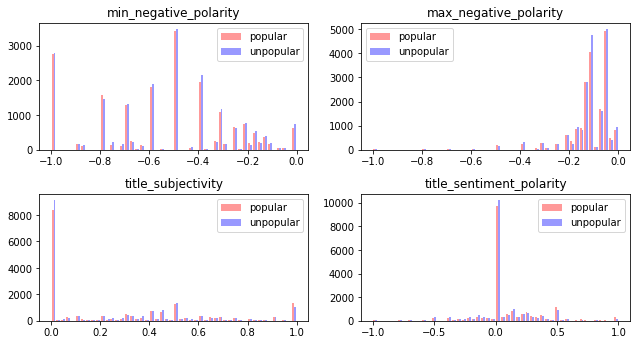

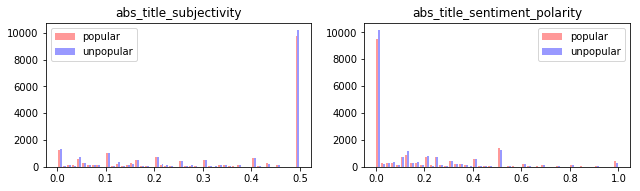

In [12]:
#show a series of dual histograms
for a in np.arange(0, X_df.shape[1], 4):
    b = min(a + 4, X_df.shape[1])
    plot_hist(X_df, y, range(a, b))

## Data Preprocessing

### Short lived articles

Below is a histogram analysis of popularity for articles that have only had a lifetime of 21 days or less. It seems that the short lived articles are not significantly skewed toward low shares, so I will not remove any rows.

Text(0.5,1,'High vs Low Popularity for Short Lived Articles')

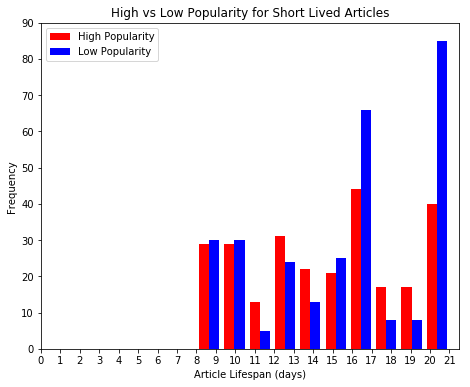

In [13]:
#show chart of popularity for short lived articles
td = all_data[['timedelta', 'shares']]
td = td[td.timedelta < 22]

high_pop = td[td.shares - np.median(td.shares) > 0]
low_pop = td[td.shares - np.median(td.shares) <= 0]
high_pop = high_pop.drop(labels=['shares'], axis=1)
low_pop = low_pop.drop(labels=['shares'], axis=1)

plt.figure(figsize=(7.5, 6))
plt.hist([high_pop.values, low_pop.values], color=['red', 'blue'])
plt.xlabel("Article Lifespan (days)")
plt.ylabel("Frequency")
plt.legend(['High Popularity', 'Low Popularity'])
plt.xticks(range(0, 22))
plt.yticks(range(0, 100, 10))
plt.title('High vs Low Popularity for Short Lived Articles')

### Scaling

I'll scale the data using Scikit-Learn's StandardScaler. Later when running GridSearch, I'll vary the scaler to see if I can improve results. The other two scalers I'll work with are the MinMaxScaler and the RobustScaler.

In [14]:
# scale the data
X = StandardScaler().fit_transform(X=X_df)

### Splitting

Next I'll split the data into training, testing and validation sets. The training set will be 50%, and the testing and validation sets will be 25% each.

In [15]:
# split the data into train, validation, test sets
# train 50%, validation 25%, test 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3333, random_state=42)

In [16]:
y_train, y_val, y_test = [y.values.ravel() for y in [y_train, y_val, y_test]]

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
print("Validation set has {} samples.".format(X_val.shape[0]))

Training set has 19231 samples.
Testing set has 9616 samples.
Validation set has 9615 samples.


## Implementation

### Default Classifiers

Run an initial baseline test against each of the classifiers using their default hyperparameters. They are all trained on the training set, and tested against the validation set.

In [17]:
#first run each classifier with default config
#KNN
clf = KNeighborsClassifier()
clf.fit(X=X_train, y=y_train)
classifier_score(clf, 'KNN', X_val, y_val)

KNN Accuracy score on the validation data: 0.6111
KNN Precision score on the validation data: 0.6048
KNN Recall score on the validation data: 0.5664
KNN F1 score on the validation data: 0.5850
KNN AUC of ROC on the validation data: 0.6097




In [18]:
#SVM
clf = SVC(random_state=42)
clf.fit(X=X_train, y=y_train)
classifier_score(clf, "SVM", X_val, y_val)

SVM Accuracy score on the validation data: 0.6570
SVM Precision score on the validation data: 0.6500
SVM Recall score on the validation data: 0.6307
SVM F1 score on the validation data: 0.6402
SVM AUC of ROC on the validation data: 0.6562




In [19]:
#Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X=X_train, y=y_train)
classifier_score(clf, 'Random Forest', X_val, y_val)

Random Forest Accuracy score on the validation data: 0.6251
Random Forest Precision score on the validation data: 0.6334
Random Forest Recall score on the validation data: 0.5344
Random Forest F1 score on the validation data: 0.5797
Random Forest AUC of ROC on the validation data: 0.6222




In [20]:
#AdaBoost
clf = AdaBoostClassifier(random_state=42)
clf.fit(X=X_train, y=y_train)
classifier_score(clf, "AdaBoost", X_val, y_val)

AdaBoost Accuracy score on the validation data: 0.6612
AdaBoost Precision score on the validation data: 0.6496
AdaBoost Recall score on the validation data: 0.6507
AdaBoost F1 score on the validation data: 0.6501
AdaBoost AUC of ROC on the validation data: 0.6608




In [21]:
#XGBoost
clf = XGBClassifier(random_state=42)
clf.fit(X=X_train, y=y_train)
classifier_score(clf, "XGBoost", X_val, y_val)

XGBoost Accuracy score on the validation data: 0.6707
XGBoost Precision score on the validation data: 0.6601
XGBoost Recall score on the validation data: 0.6584
XGBoost F1 score on the validation data: 0.6593
XGBoost AUC of ROC on the validation data: 0.6703




C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
#Naive Bayes
clf = GaussianNB()
clf.fit(X=X_train, y=y_train)
classifier_score(clf, "Naive Bayes", X_val, y_val)

Naive Bayes Accuracy score on the validation data: 0.6070
Naive Bayes Precision score on the validation data: 0.6394
Naive Bayes Recall score on the validation data: 0.4304
Naive Bayes F1 score on the validation data: 0.5145
Naive Bayes AUC of ROC on the validation data: 0.6014




### Default classifier results

XGBoost produced the best results, with an AUC of ROC score on the validation set of 0.6703. 

### Default Neural Net

I'll also run an initial baseline test using a neural net. Keras does not allow the user to specify AUC of ROC as the metric to be evaluated by the model during training and testing. The default choice is the accuracy score, which correlates very well with AUC of ROC; so for my purposes, this is only a minor issue.

My initial neural net is comprised of 2 fully connected layers with two Dropout layers, followed by the output layer. It uses a <code>sparse_categorical_crossentropy</code> loss function, and <code>adam</code> optimizer. The first layer has 20 units, the second has 10. The Dropout layers use a rate of 0.5. As it is training the model will test against the validation set after each of 300 epochs, with a batch size of 32.

In [23]:
basic_nn = basic_neural_net()
model, callbacks = fit_nn(basic_nn, X_train, y_train, X_val, y_val)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                1180      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________
Train on 19231 samples, validate on 9615 samples
Epoch 1/300

Epoch 00001: saving model to ./chkpt/chkpt-01.hdf5
Best epoch: 1
           ac


Epoch 00020: saving model to ./chkpt/chkpt-20.hdf5
Best epoch: 17
           acc val: 0.6521  --        Best acc val: 0.6543
     precision val: 0.6325  --  Best precision val: 0.6335
        recall val: 0.6707  --     Best recall val: 0.6773
            f1 val: 0.6510  --         Best f1 val: 0.6547
       ROC AUC val: 0.6527  --    Best ROC AUC val: 0.6550


Epoch 21/300

Epoch 00021: saving model to ./chkpt/chkpt-21.hdf5
Best epoch: 17
           acc val: 0.6513  --        Best acc val: 0.6543
     precision val: 0.6315  --  Best precision val: 0.6335
        recall val: 0.6707  --     Best recall val: 0.6773
            f1 val: 0.6505  --         Best f1 val: 0.6547
       ROC AUC val: 0.6519  --    Best ROC AUC val: 0.6550


Epoch 22/300

Epoch 00022: saving model to ./chkpt/chkpt-22.hdf5
Best epoch: 17
           acc val: 0.6522  --        Best acc val: 0.6543
     precision val: 0.6327  --  Best precision val: 0.6335
        recall val: 0.6702  --     Best recall val: 0.6773
  


Epoch 00042: saving model to ./chkpt/chkpt-42.hdf5
Best epoch: 37
           acc val: 0.6525  --        Best acc val: 0.6548
     precision val: 0.6283  --  Best precision val: 0.6293
        recall val: 0.6900  --     Best recall val: 0.6973
            f1 val: 0.6577  --         Best f1 val: 0.6616
       ROC AUC val: 0.6537  --    Best ROC AUC val: 0.6561


Epoch 43/300

Epoch 00043: saving model to ./chkpt/chkpt-43.hdf5
Best epoch: 37
           acc val: 0.6543  --        Best acc val: 0.6548
     precision val: 0.6274  --  Best precision val: 0.6293
        recall val: 0.7027  --     Best recall val: 0.6973
            f1 val: 0.6629  --         Best f1 val: 0.6616
       ROC AUC val: 0.6558  --    Best ROC AUC val: 0.6561


Epoch 44/300

Epoch 00044: saving model to ./chkpt/chkpt-44.hdf5
Best epoch: 37
           acc val: 0.6536  --        Best acc val: 0.6548
     precision val: 0.6291  --  Best precision val: 0.6293
        recall val: 0.6920  --     Best recall val: 0.6973
  


Epoch 00064: saving model to ./chkpt/chkpt-64.hdf5
Best epoch: 48
           acc val: 0.6544  --        Best acc val: 0.6566
     precision val: 0.6316  --  Best precision val: 0.6307
        recall val: 0.6857  --     Best recall val: 0.7001
            f1 val: 0.6575  --         Best f1 val: 0.6636
       ROC AUC val: 0.6554  --    Best ROC AUC val: 0.6579


Epoch 65/300

Epoch 00065: saving model to ./chkpt/chkpt-65.hdf5
Best epoch: 48
           acc val: 0.6556  --        Best acc val: 0.6566
     precision val: 0.6327  --  Best precision val: 0.6307
        recall val: 0.6872  --     Best recall val: 0.7001
            f1 val: 0.6588  --         Best f1 val: 0.6636
       ROC AUC val: 0.6566  --    Best ROC AUC val: 0.6579


Epoch 66/300

Epoch 00066: saving model to ./chkpt/chkpt-66.hdf5
Best epoch: 48
           acc val: 0.6554  --        Best acc val: 0.6566
     precision val: 0.6380  --  Best precision val: 0.6307
        recall val: 0.6653  --     Best recall val: 0.7001
  


Epoch 00086: saving model to ./chkpt/chkpt-86.hdf5
Best epoch: 83
           acc val: 0.6565  --        Best acc val: 0.6593
     precision val: 0.6389  --  Best precision val: 0.6378
        recall val: 0.6668  --     Best recall val: 0.6847
            f1 val: 0.6526  --         Best f1 val: 0.6604
       ROC AUC val: 0.6568  --    Best ROC AUC val: 0.6601


Epoch 87/300

Epoch 00087: saving model to ./chkpt/chkpt-87.hdf5
Best epoch: 83
           acc val: 0.6559  --        Best acc val: 0.6593
     precision val: 0.6321  --  Best precision val: 0.6378
        recall val: 0.6907  --     Best recall val: 0.6847
            f1 val: 0.6601  --         Best f1 val: 0.6604
       ROC AUC val: 0.6569  --    Best ROC AUC val: 0.6601


Epoch 88/300

Epoch 00088: saving model to ./chkpt/chkpt-88.hdf5
Best epoch: 83
           acc val: 0.6586  --        Best acc val: 0.6593
     precision val: 0.6361  --  Best precision val: 0.6378
        recall val: 0.6877  --     Best recall val: 0.6847
  


Epoch 00108: saving model to ./chkpt/chkpt-108.hdf5
Best epoch: 89
           acc val: 0.6577  --        Best acc val: 0.6598
     precision val: 0.6374  --  Best precision val: 0.6415
        recall val: 0.6784  --     Best recall val: 0.6730
            f1 val: 0.6573  --         Best f1 val: 0.6569
       ROC AUC val: 0.6584  --    Best ROC AUC val: 0.6602


Epoch 109/300

Epoch 00109: saving model to ./chkpt/chkpt-109.hdf5
Best epoch: 89
           acc val: 0.6547  --        Best acc val: 0.6598
     precision val: 0.6319  --  Best precision val: 0.6415
        recall val: 0.6857  --     Best recall val: 0.6730
            f1 val: 0.6577  --         Best f1 val: 0.6569
       ROC AUC val: 0.6557  --    Best ROC AUC val: 0.6602


Epoch 110/300

Epoch 00110: saving model to ./chkpt/chkpt-110.hdf5
Best epoch: 89
           acc val: 0.6560  --        Best acc val: 0.6598
     precision val: 0.6341  --  Best precision val: 0.6415
        recall val: 0.6831  --     Best recall val: 0.67


Epoch 00130: saving model to ./chkpt/chkpt-130.hdf5
Best epoch: 89
           acc val: 0.6577  --        Best acc val: 0.6598
     precision val: 0.6348  --  Best precision val: 0.6415
        recall val: 0.6887  --     Best recall val: 0.6730
            f1 val: 0.6607  --         Best f1 val: 0.6569
       ROC AUC val: 0.6587  --    Best ROC AUC val: 0.6602


Epoch 131/300

Epoch 00131: saving model to ./chkpt/chkpt-131.hdf5
Best epoch: 89
           acc val: 0.6567  --        Best acc val: 0.6598
     precision val: 0.6335  --  Best precision val: 0.6415
        recall val: 0.6892  --     Best recall val: 0.6730
            f1 val: 0.6601  --         Best f1 val: 0.6569
       ROC AUC val: 0.6577  --    Best ROC AUC val: 0.6602


Epoch 132/300

Epoch 00132: saving model to ./chkpt/chkpt-132.hdf5
Best epoch: 89
           acc val: 0.6593  --        Best acc val: 0.6598
     precision val: 0.6379  --  Best precision val: 0.6415
        recall val: 0.6840  --     Best recall val: 0.67


Epoch 00152: saving model to ./chkpt/chkpt-152.hdf5
Best epoch: 144
           acc val: 0.6555  --        Best acc val: 0.6602
     precision val: 0.6286  --  Best precision val: 0.6375
        recall val: 0.7038  --     Best recall val: 0.6900
            f1 val: 0.6641  --         Best f1 val: 0.6627
       ROC AUC val: 0.6570  --    Best ROC AUC val: 0.6612


Epoch 153/300

Epoch 00153: saving model to ./chkpt/chkpt-153.hdf5
Best epoch: 144
           acc val: 0.6535  --        Best acc val: 0.6602
     precision val: 0.6260  --  Best precision val: 0.6375
        recall val: 0.7051  --     Best recall val: 0.6900
            f1 val: 0.6632  --         Best f1 val: 0.6627
       ROC AUC val: 0.6551  --    Best ROC AUC val: 0.6612


Epoch 154/300

Epoch 00154: saving model to ./chkpt/chkpt-154.hdf5
Best epoch: 144
           acc val: 0.6546  --        Best acc val: 0.6602
     precision val: 0.6283  --  Best precision val: 0.6375
        recall val: 0.7006  --     Best recall val: 0


Epoch 00174: saving model to ./chkpt/chkpt-174.hdf5
Best epoch: 144
           acc val: 0.6516  --        Best acc val: 0.6602
     precision val: 0.6214  --  Best precision val: 0.6375
        recall val: 0.7165  --     Best recall val: 0.6900
            f1 val: 0.6655  --         Best f1 val: 0.6627
       ROC AUC val: 0.6536  --    Best ROC AUC val: 0.6612


Epoch 175/300

Epoch 00175: saving model to ./chkpt/chkpt-175.hdf5
Best epoch: 144
           acc val: 0.6534  --        Best acc val: 0.6602
     precision val: 0.6287  --  Best precision val: 0.6375
        recall val: 0.6926  --     Best recall val: 0.6900
            f1 val: 0.6591  --         Best f1 val: 0.6627
       ROC AUC val: 0.6546  --    Best ROC AUC val: 0.6612


Epoch 176/300

Epoch 00176: saving model to ./chkpt/chkpt-176.hdf5
Best epoch: 144
           acc val: 0.6522  --        Best acc val: 0.6602
     precision val: 0.6247  --  Best precision val: 0.6375
        recall val: 0.7042  --     Best recall val: 0


Epoch 00196: saving model to ./chkpt/chkpt-196.hdf5
Best epoch: 144
           acc val: 0.6530  --        Best acc val: 0.6602
     precision val: 0.6266  --  Best precision val: 0.6375
        recall val: 0.6999  --     Best recall val: 0.6900
            f1 val: 0.6613  --         Best f1 val: 0.6627
       ROC AUC val: 0.6545  --    Best ROC AUC val: 0.6612


Epoch 197/300

Epoch 00197: saving model to ./chkpt/chkpt-197.hdf5
Best epoch: 144
           acc val: 0.6548  --        Best acc val: 0.6602
     precision val: 0.6256  --  Best precision val: 0.6375
        recall val: 0.7137  --     Best recall val: 0.6900
            f1 val: 0.6667  --         Best f1 val: 0.6627
       ROC AUC val: 0.6567  --    Best ROC AUC val: 0.6612


Epoch 198/300

Epoch 00198: saving model to ./chkpt/chkpt-198.hdf5
Best epoch: 144
           acc val: 0.6518  --        Best acc val: 0.6602
     precision val: 0.6219  --  Best precision val: 0.6375
        recall val: 0.7152  --     Best recall val: 0


Epoch 00218: saving model to ./chkpt/chkpt-218.hdf5
Best epoch: 144
           acc val: 0.6519  --        Best acc val: 0.6602
     precision val: 0.6239  --  Best precision val: 0.6375
        recall val: 0.7064  --     Best recall val: 0.6900
            f1 val: 0.6626  --         Best f1 val: 0.6627
       ROC AUC val: 0.6536  --    Best ROC AUC val: 0.6612


Epoch 219/300

Epoch 00219: saving model to ./chkpt/chkpt-219.hdf5
Best epoch: 144
           acc val: 0.6544  --        Best acc val: 0.6602
     precision val: 0.6276  --  Best precision val: 0.6375
        recall val: 0.7027  --     Best recall val: 0.6900
            f1 val: 0.6630  --         Best f1 val: 0.6627
       ROC AUC val: 0.6559  --    Best ROC AUC val: 0.6612


Epoch 220/300

Epoch 00220: saving model to ./chkpt/chkpt-220.hdf5
Best epoch: 144
           acc val: 0.6559  --        Best acc val: 0.6602
     precision val: 0.6324  --  Best precision val: 0.6375
        recall val: 0.6894  --     Best recall val: 0


Epoch 00240: saving model to ./chkpt/chkpt-240.hdf5
Best epoch: 144
           acc val: 0.6512  --        Best acc val: 0.6602
     precision val: 0.6219  --  Best precision val: 0.6375
        recall val: 0.7115  --     Best recall val: 0.6900
            f1 val: 0.6637  --         Best f1 val: 0.6627
       ROC AUC val: 0.6531  --    Best ROC AUC val: 0.6612


Epoch 241/300

Epoch 00241: saving model to ./chkpt/chkpt-241.hdf5
Best epoch: 144
           acc val: 0.6505  --        Best acc val: 0.6602
     precision val: 0.6227  --  Best precision val: 0.6375
        recall val: 0.7049  --     Best recall val: 0.6900
            f1 val: 0.6612  --         Best f1 val: 0.6627
       ROC AUC val: 0.6522  --    Best ROC AUC val: 0.6612


Epoch 242/300

Epoch 00242: saving model to ./chkpt/chkpt-242.hdf5
Best epoch: 144
           acc val: 0.6520  --        Best acc val: 0.6602
     precision val: 0.6245  --  Best precision val: 0.6375
        recall val: 0.7042  --     Best recall val: 0


Epoch 00262: saving model to ./chkpt/chkpt-262.hdf5
Best epoch: 144
           acc val: 0.6477  --        Best acc val: 0.6602
     precision val: 0.6151  --  Best precision val: 0.6375
        recall val: 0.7266  --     Best recall val: 0.6900
            f1 val: 0.6662  --         Best f1 val: 0.6627
       ROC AUC val: 0.6502  --    Best ROC AUC val: 0.6612


Epoch 263/300

Epoch 00263: saving model to ./chkpt/chkpt-263.hdf5
Best epoch: 144
           acc val: 0.6487  --        Best acc val: 0.6602
     precision val: 0.6192  --  Best precision val: 0.6375
        recall val: 0.7111  --     Best recall val: 0.6900
            f1 val: 0.6620  --         Best f1 val: 0.6627
       ROC AUC val: 0.6506  --    Best ROC AUC val: 0.6612


Epoch 264/300

Epoch 00264: saving model to ./chkpt/chkpt-264.hdf5
Best epoch: 144
           acc val: 0.6500  --        Best acc val: 0.6602
     precision val: 0.6208  --  Best precision val: 0.6375
        recall val: 0.7109  --     Best recall val: 0


Epoch 00284: saving model to ./chkpt/chkpt-284.hdf5
Best epoch: 144
           acc val: 0.6502  --        Best acc val: 0.6602
     precision val: 0.6197  --  Best precision val: 0.6375
        recall val: 0.7171  --     Best recall val: 0.6900
            f1 val: 0.6649  --         Best f1 val: 0.6627
       ROC AUC val: 0.6523  --    Best ROC AUC val: 0.6612


Epoch 285/300

Epoch 00285: saving model to ./chkpt/chkpt-285.hdf5
Best epoch: 144
           acc val: 0.6516  --        Best acc val: 0.6602
     precision val: 0.6242  --  Best precision val: 0.6375
        recall val: 0.7031  --     Best recall val: 0.6900
            f1 val: 0.6613  --         Best f1 val: 0.6627
       ROC AUC val: 0.6532  --    Best ROC AUC val: 0.6612


Epoch 286/300

Epoch 00286: saving model to ./chkpt/chkpt-286.hdf5
Best epoch: 144
           acc val: 0.6493  --        Best acc val: 0.6602
     precision val: 0.6190  --  Best precision val: 0.6375
        recall val: 0.7156  --     Best recall val: 0

In [24]:
# reprint the best scores, which can also be found at the bottom of the scroll window above
print_scores(model, callbacks, X_val, y_val, loss_func="sparse_categorical_crossentropy", data_type="validation")

Created model and loaded weights from file ./chkpt/chkpt-144.hdf5
 Accuracy score on the validation data: 0.6602
 Precision score on the validation data: 0.6375
 Recall score on the validation data: 0.6900
 F1 score on the validation data: 0.6627
 AUC of ROC on the validation data: 0.6612




### Default Neural Net Result

The default neural net was competitive with the best classifier (XGBoost). The neural net had an AUC of ROC score on the validation set of 0.6612 vs 0.6703 for XGBoost.

## Refinement

### Classifiers

The hyperparameters for each classifier need to be tuned. I'll use Scikit-Learn's GridSearch to test different parameters and narrow down the possibilies. GridSearch will test the different combinations of hyperparameters against the validation set. What you see below is the final results of the effort. There were several iterations of hyperparameter combinations for each of the classifiers. Showing all of the iterations would be tedious and counterproductive; only the final iterations are shown below.

In [26]:
# GridSearch KNN
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[30, 37, 40], 'weights':['uniform', 'distance'], 'algorithm':['auto']}
knn_clf, results = gridsearch(knn, parameters, X_train, y_train, X_val, y_val)
print(results[['mean_test_score', 'param_n_neighbors', 'param_weights', 'param_algorithm']].to_string())
print("best n_neighbors:", knn_clf.n_neighbors)
print("best weights:", knn_clf.weights)
print("best algo:", knn_clf.algorithm)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=30, weights=uniform, algorithm=auto .................
[CV]  n_neighbors=30, weights=uniform, algorithm=auto, score=0.6274393706188754, total=  20.9s
[CV] n_neighbors=30, weights=uniform, algorithm=auto .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  n_neighbors=30, weights=uniform, algorithm=auto, score=0.629293031765417, total=  21.5s
[CV] n_neighbors=30, weights=uniform, algorithm=auto .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  n_neighbors=30, weights=uniform, algorithm=auto, score=0.6299959615612285, total=  20.6s
[CV] n_neighbors=30, weights=distance, algorithm=auto ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


[CV]  n_neighbors=30, weights=distance, algorithm=auto, score=0.6310163420531308, total=  20.0s
[CV] n_neighbors=30, weights=distance, algorithm=auto ................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s


[CV]  n_neighbors=30, weights=distance, algorithm=auto, score=0.6314149645770116, total=  20.7s
[CV] n_neighbors=30, weights=distance, algorithm=auto ................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s


[CV]  n_neighbors=30, weights=distance, algorithm=auto, score=0.6342837359569815, total=  20.3s
[CV] n_neighbors=37, weights=uniform, algorithm=auto .................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.1min remaining:    0.0s


[CV]  n_neighbors=37, weights=uniform, algorithm=auto, score=0.6372480479292663, total=  21.3s
[CV] n_neighbors=37, weights=uniform, algorithm=auto .................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.1min remaining:    0.0s


[CV]  n_neighbors=37, weights=uniform, algorithm=auto, score=0.634372721806479, total=  20.3s
[CV] n_neighbors=37, weights=uniform, algorithm=auto .................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.1min remaining:    0.0s


[CV]  n_neighbors=37, weights=uniform, algorithm=auto, score=0.6297658056003839, total=  20.4s
[CV] n_neighbors=37, weights=distance, algorithm=auto ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.2min remaining:    0.0s


[CV]  n_neighbors=37, weights=distance, algorithm=auto, score=0.6378639918695594, total=  20.3s
[CV] n_neighbors=37, weights=distance, algorithm=auto ................
[CV]  n_neighbors=37, weights=distance, algorithm=auto, score=0.6351488653427961, total=  20.9s
[CV] n_neighbors=37, weights=distance, algorithm=auto ................
[CV]  n_neighbors=37, weights=distance, algorithm=auto, score=0.630534063082205, total=  20.6s
[CV] n_neighbors=40, weights=uniform, algorithm=auto .................
[CV]  n_neighbors=40, weights=uniform, algorithm=auto, score=0.6333061429714066, total=  18.3s
[CV] n_neighbors=40, weights=uniform, algorithm=auto .................
[CV]  n_neighbors=40, weights=uniform, algorithm=auto, score=0.6338346202855023, total=  20.5s
[CV] n_neighbors=40, weights=uniform, algorithm=auto .................
[CV]  n_neighbors=40, weights=uniform, algorithm=auto, score=0.6287793672775082, total=  20.3s
[CV] n_neighbors=40, weights=distance, algorithm=auto ................
[C

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 18.5min finished



Optimized Model
------
Optimized Model accuracy score on the validation data: 0.6361
Optimized Model Precision score on the validation data: 0.6396
Optimized Model Recall score on the validation data: 0.5677
Optimized Model F1 score on the validation data: 0.6015
Optimized Model AUC of ROC on the validation data: 0.6339
   mean_test_score param_n_neighbors param_weights param_algorithm
3         0.634516                37      distance            auto
2         0.633796                37       uniform            auto
5         0.633576                40      distance            auto
1         0.632238                30      distance            auto
4         0.631973                40       uniform            auto
0         0.628909                30       uniform            auto
best n_neighbors: 37
best weights: distance
best algo: auto


In [27]:
# GridSearch SVM
svm = SVC(random_state=42)
parameters = {
    'gamma': [1, 2],
    'C': [1, 2],
    'kernel': ['linear']
}

svm_clf, results = gridsearch(svm, parameters, X_train, y_train, X_val, y_val)
print(results[['mean_test_score', 'param_gamma', 'param_C', 'param_kernel']].to_string())
print("best gamma:", svm_clf.gamma)
print("best C:", svm_clf.C)
print("best kernel:", svm_clf.kernel)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] gamma=1, kernel=linear, C=1 .....................................
[CV]  gamma=1, kernel=linear, C=1, score=0.6461347315687401, total= 1.1min
[CV] gamma=1, kernel=linear, C=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  gamma=1, kernel=linear, C=1, score=0.6401294442298227, total= 1.2min
[CV] gamma=1, kernel=linear, C=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV]  gamma=1, kernel=linear, C=1, score=0.6408950730268118, total= 1.1min
[CV] gamma=2, kernel=linear, C=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s


[CV]  gamma=2, kernel=linear, C=1, score=0.6461347315687401, total= 1.2min
[CV] gamma=2, kernel=linear, C=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.2min remaining:    0.0s


[CV]  gamma=2, kernel=linear, C=1, score=0.6401294442298227, total= 1.1min
[CV] gamma=2, kernel=linear, C=1 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min remaining:    0.0s


[CV]  gamma=2, kernel=linear, C=1, score=0.6408950730268118, total= 1.2min
[CV] gamma=1, kernel=linear, C=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.8min remaining:    0.0s


[CV]  gamma=1, kernel=linear, C=2, score=0.6459854295217449, total= 1.9min
[CV] gamma=1, kernel=linear, C=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.9min remaining:    0.0s


[CV]  gamma=1, kernel=linear, C=2, score=0.6402867758849515, total= 1.9min
[CV] gamma=1, kernel=linear, C=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.0min remaining:    0.0s


[CV]  gamma=1, kernel=linear, C=2, score=0.6408977017116437, total= 1.8min
[CV] gamma=2, kernel=linear, C=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.0min remaining:    0.0s


[CV]  gamma=2, kernel=linear, C=2, score=0.6459854295217449, total= 1.9min
[CV] gamma=2, kernel=linear, C=2 .....................................
[CV]  gamma=2, kernel=linear, C=2, score=0.6402867758849515, total= 1.9min
[CV] gamma=2, kernel=linear, C=2 .....................................
[CV]  gamma=2, kernel=linear, C=2, score=0.6408977017116437, total= 1.9min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 20.0min finished



Optimized Model
------
Optimized Model accuracy score on the validation data: 0.6384
Optimized Model Precision score on the validation data: 0.6256
Optimized Model Recall score on the validation data: 0.6290
Optimized Model F1 score on the validation data: 0.6273
Optimized Model AUC of ROC on the validation data: 0.6381
   mean_test_score param_gamma param_C param_kernel
2         0.642390           1       2       linear
3         0.642390           2       2       linear
0         0.642387           1       1       linear
1         0.642387           2       1       linear
best gamma: 1
best C: 2
best kernel: linear


In [28]:
rf = RandomForestClassifier(random_state=42)
parameters = {
    'min_samples_split': [20, 25],
    'n_estimators' : [500, 600],
    'max_depth': [17],
    'max_features': ['auto'],
    'criterion' :['entropy']
}
rf_clf, results = gridsearch(rf, parameters, X_train, y_train, X_val, y_val)
print(results[['mean_test_score', 'param_min_samples_split', 'param_n_estimators', 'param_max_depth',
               'param_max_features', 'param_criterion']].to_string())
print("best min_samples_split:", rf_clf.min_samples_split)
print("best n_estimators:", rf_clf.n_estimators)
print("best max_depth:", rf_clf.max_depth)
print("best max_features:", rf_clf.max_features)
print("best criterion:", rf_clf.criterion)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] min_samples_split=20, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy 
[CV]  min_samples_split=20, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy, score=0.6660992085823565, total=  54.9s
[CV] min_samples_split=20, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.3s remaining:    0.0s


[CV]  min_samples_split=20, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy, score=0.6662145653284649, total=  53.7s
[CV] min_samples_split=20, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  min_samples_split=20, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy, score=0.6623233329075513, total=  50.3s
[CV] min_samples_split=20, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV]  min_samples_split=20, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy, score=0.6656272136169695, total= 1.1min
[CV] min_samples_split=20, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.8min remaining:    0.0s


[CV]  min_samples_split=20, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy, score=0.6674889906784888, total= 1.1min
[CV] min_samples_split=20, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s


[CV]  min_samples_split=20, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy, score=0.6634036250147985, total= 1.0min
[CV] min_samples_split=25, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.0min remaining:    0.0s


[CV]  min_samples_split=25, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy, score=0.6620460570536264, total=  52.5s
[CV] min_samples_split=25, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.9min remaining:    0.0s


[CV]  min_samples_split=25, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy, score=0.6666865602938518, total=  53.6s
[CV] min_samples_split=25, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.8min remaining:    0.0s


[CV]  min_samples_split=25, max_depth=17, max_features=auto, n_estimators=500, criterion=entropy, score=0.6584215857473098, total=  47.3s
[CV] min_samples_split=25, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.6min remaining:    0.0s


[CV]  min_samples_split=25, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy, score=0.6619021080787202, total= 1.0min
[CV] min_samples_split=25, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy 
[CV]  min_samples_split=25, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy, score=0.666198793219473, total= 1.1min
[CV] min_samples_split=25, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy 
[CV]  min_samples_split=25, max_depth=17, max_features=auto, n_estimators=600, criterion=entropy, score=0.6581042937522198, total=  59.4s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 11.8min finished



Optimized Model
------
Optimized Model accuracy score on the validation data: 0.6713
Optimized Model Precision score on the validation data: 0.6580
Optimized Model Recall score on the validation data: 0.6679
Optimized Model F1 score on the validation data: 0.6629
Optimized Model AUC of ROC on the validation data: 0.6712
   mean_test_score param_min_samples_split param_n_estimators param_max_depth param_max_features param_criterion
1         0.665507                      20                600              17               auto         entropy
0         0.664879                      20                500              17               auto         entropy
2         0.662385                      25                500              17               auto         entropy
3         0.662068                      25                600              17               auto         entropy
best min_samples_split: 20
best n_estimators: 600
best max_depth: 17
best max_features: auto
best criterion: ent

In [29]:
# AdaBoost's best config uses the RandomForest classifier from above as its base classifier
ada = AdaBoostClassifier(random_state=42)
parameters = {
    'base_estimator': [rf_clf],
    'n_estimators' : [25, 30],
    'learning_rate': [1.3, 1.5],
    'algorithm': ['SAMME.R']
}
ada_clf, results = gridsearch(ada, parameters, X_train, y_train, X_val, y_val)
print(results[['mean_test_score', 'param_base_estimator', 'param_n_estimators', 'param_learning_rate',
               'param_algorithm']].to_string())
print("best base_estimator:", ada_clf.base_estimator)
print("best n_estimators:", ada_clf.n_estimators)
print("best learning_rate", ada_clf.learning_rate)
print("best algorithm", ada_clf.algorithm)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=1.3, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False) 
[CV]  learning_rate=1.3, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=4

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV]  learning_rate=1.3, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6738659853634829, total= 4.8min
[CV] learning_rate=1.3, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.6min remaining:    0.0s


[CV]  learning_rate=1.3, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6653100056701705, total= 3.6min
[CV] learning_rate=1.3, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.3min remaining:    0.0s


[CV]  learning_rate=1.3, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6671844709519923, total= 3.6min
[CV] learning_rate=1.3, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.9min remaining:    0.0s


[CV]  learning_rate=1.3, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6738659853634829, total= 4.8min
[CV] learning_rate=1.3, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.9min remaining:    0.0s


[CV]  learning_rate=1.3, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6653100056701705, total= 3.6min
[CV] learning_rate=1.5, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 24.6min remaining:    0.0s


[CV]  learning_rate=1.5, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.664547304319423, total= 3.6min
[CV] learning_rate=1.5, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_st

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 28.2min remaining:    0.0s


[CV]  learning_rate=1.5, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6733207766575903, total= 2.3min
[CV] learning_rate=1.5, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 30.6min remaining:    0.0s


[CV]  learning_rate=1.5, algorithm=SAMME.R, n_estimators=25, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.6645233473945255, total= 3.6min
[CV] learning_rate=1.5, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_s

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 34.3min remaining:    0.0s


[CV]  learning_rate=1.5, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), score=0.664547304319423, total= 3.6min
[CV] learning_rate=1.5, algorithm=SAMME.R, n_estimators=30, base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_st

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 44.1min finished



Optimized Model
------
Optimized Model accuracy score on the validation data: 0.6759
Optimized Model Precision score on the validation data: 0.6611
Optimized Model Recall score on the validation data: 0.6773
Optimized Model F1 score on the validation data: 0.6691
Optimized Model AUC of ROC on the validation data: 0.6760
   mean_test_score                               param_base_estimator param_n_estimators param_learning_rate param_algorithm
0         0.668787  (DecisionTreeClassifier(class_weight=None, cri...                 25                 1.3         SAMME.R
1         0.668787  (DecisionTreeClassifier(class_weight=None, cri...                 30                 1.3         SAMME.R
2         0.667464  (DecisionTreeClassifier(class_weight=None, cri...                 25                 1.5         SAMME.R
3         0.667464  (DecisionTreeClassifier(class_weight=None, cri...                 30                 1.5         SAMME.R
best base_estimator: RandomForestClassifier(bootstra

In [25]:
xgb = XGBClassifier(random_state=42)
parameters = {
    'max_depth': [5],
    'learning_rate': [0.05, 0.07],
    'n_estimators': [200, 300],
    'gamma': [0.25],
    'subsample': [0.8],
    'colsample_bytree': [0.95]
}

xgb_clf, results = gridsearch(xgb, parameters, X_train, y_train, X_val, y_val)
print(results[['mean_test_score', 'param_max_depth', 'param_learning_rate', 'param_n_estimators', 
               'param_gamma', 'param_subsample', 'param_colsample_bytree']].to_string())
print("best max_depth:", xgb_clf.max_depth)
print("best learning_rate:", xgb_clf.learning_rate)
print("best n_estimators:", xgb_clf.n_estimators)
print("best gamma:", xgb_clf.gamma)
print("best subsample:", xgb_clf.subsample)
print("best colsample_bytree:", xgb_clf.colsample_bytree)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=200 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=200, score=0.677274525197105, total=  13.4s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=200 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=200, score=0.6723031835515206, total=  13.2s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=200 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.7s remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=200, score=0.666041461564344, total=  13.4s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=300 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.7s remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=300, score=0.6712590347690792, total=  15.6s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=300 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=300, score=0.6701163124887065, total=  19.5s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=300 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.05, max_depth=5, n_estimators=300, score=0.6644734023827179, total=  19.5s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=200 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=200, score=0.6656138309367468, total=  12.7s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=200 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.0min remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=200, score=0.6691907233517561, total=  12.9s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=200 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=200, score=0.6643765304787244, total=  13.2s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=300 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=300, score=0.6630965244546827, total=  19.4s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=300 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=300, score=0.6641666251269558, total=  19.9s
[CV] gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=300 


C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.3min finished


[CV]  gamma=0.25, subsample=0.8, colsample_bytree=0.95, learning_rate=0.07, max_depth=5, n_estimators=300, score=0.6620454711849411, total=  19.6s

Optimized Model
------
Optimized Model Accuracy score on the validation data: 0.6786
Optimized Model Precision score on the validation data: 0.6667
Optimized Model Recall score on the validation data: 0.6713
Optimized Model F1 score on the validation data: 0.6690
Optimized Model AUC of ROC on the validation data: 0.6784


   mean_test_score param_max_depth param_learning_rate param_n_estimators param_gamma param_subsample param_colsample_bytree
0         0.671873               5                0.05                200        0.25             0.8                   0.95
1         0.668616               5                0.05                300        0.25             0.8                   0.95
2         0.666394               5                0.07                200        0.25             0.8                   0.95
3         0.663103          

C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Note: Naive Bayes classifier does not have any hyperparameters to tune.

### Neural Net

The hyperparameters for the neural net need to be tuned as well. I tuned these manually with several iterations of different combinations including the number of layers, the units per layer, the loss function, optimizer, activation, and batch size.

Again, what you see below is just the final results of the effort.

In [37]:
num_classes = 2
model = Sequential()
model.add(Dense(40, activation='relu', input_dim=58))
model.add(Dropout(0.6))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

nn_model, callbacks = fit_nn(model, X_train, y_train, X_val, y_val)
print_scores(nn_model, callbacks, X_val, y_val, loss_func="binary_crossentropy", optimizer="adam", data_type="validation")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                2360      
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 22        
__________


Epoch 00019: saving model to ./chkpt/chkpt-19.hdf5
Best epoch: 19
           acc val: 0.6528  --        Best acc val: 0.6528
     precision val: 0.6505  --  Best precision val: 0.6505
        recall val: 0.6103  --     Best recall val: 0.6103
            f1 val: 0.6298  --         Best f1 val: 0.6298
       ROC AUC val: 0.6515  --    Best ROC AUC val: 0.6515


Epoch 20/300

Epoch 00020: saving model to ./chkpt/chkpt-20.hdf5
Best epoch: 20
           acc val: 0.6539  --        Best acc val: 0.6539
     precision val: 0.6539  --  Best precision val: 0.6539
        recall val: 0.6047  --     Best recall val: 0.6047
            f1 val: 0.6283  --         Best f1 val: 0.6283
       ROC AUC val: 0.6523  --    Best ROC AUC val: 0.6523


Epoch 21/300

Epoch 00021: saving model to ./chkpt/chkpt-21.hdf5
Best epoch: 20
           acc val: 0.6514  --        Best acc val: 0.6539
     precision val: 0.6540  --  Best precision val: 0.6539
        recall val: 0.5933  --     Best recall val: 0.6047
  


Epoch 00041: saving model to ./chkpt/chkpt-41.hdf5
Best epoch: 40
           acc val: 0.6592  --        Best acc val: 0.6600
     precision val: 0.6578  --  Best precision val: 0.6624
        recall val: 0.6161  --     Best recall val: 0.6064
            f1 val: 0.6363  --         Best f1 val: 0.6332
       ROC AUC val: 0.6578  --    Best ROC AUC val: 0.6583


Epoch 42/300

Epoch 00042: saving model to ./chkpt/chkpt-42.hdf5
Best epoch: 40
           acc val: 0.6595  --        Best acc val: 0.6600
     precision val: 0.6577  --  Best precision val: 0.6624
        recall val: 0.6178  --     Best recall val: 0.6064
            f1 val: 0.6371  --         Best f1 val: 0.6332
       ROC AUC val: 0.6582  --    Best ROC AUC val: 0.6583


Epoch 43/300

Epoch 00043: saving model to ./chkpt/chkpt-43.hdf5
Best epoch: 40
           acc val: 0.6566  --        Best acc val: 0.6600
     precision val: 0.6565  --  Best precision val: 0.6624
        recall val: 0.6086  --     Best recall val: 0.6064
  


Epoch 00063: saving model to ./chkpt/chkpt-63.hdf5
Best epoch: 56
           acc val: 0.6585  --        Best acc val: 0.6592
     precision val: 0.6442  --  Best precision val: 0.6507
        recall val: 0.6569  --     Best recall val: 0.6380
            f1 val: 0.6505  --         Best f1 val: 0.6443
       ROC AUC val: 0.6584  --    Best ROC AUC val: 0.6585


Epoch 64/300

Epoch 00064: saving model to ./chkpt/chkpt-64.hdf5
Best epoch: 64
           acc val: 0.6596  --        Best acc val: 0.6596
     precision val: 0.6467  --  Best precision val: 0.6467
        recall val: 0.6535  --     Best recall val: 0.6535
            f1 val: 0.6501  --         Best f1 val: 0.6501
       ROC AUC val: 0.6594  --    Best ROC AUC val: 0.6594


Epoch 65/300

Epoch 00065: saving model to ./chkpt/chkpt-65.hdf5
Best epoch: 64
           acc val: 0.6579  --        Best acc val: 0.6596
     precision val: 0.6578  --  Best precision val: 0.6467
        recall val: 0.6107  --     Best recall val: 0.6535
  


Epoch 00085: saving model to ./chkpt/chkpt-85.hdf5
Best epoch: 80
           acc val: 0.6590  --        Best acc val: 0.6620
     precision val: 0.6532  --  Best precision val: 0.6649
        recall val: 0.6292  --     Best recall val: 0.6077
            f1 val: 0.6410  --         Best f1 val: 0.6350
       ROC AUC val: 0.6580  --    Best ROC AUC val: 0.6603


Epoch 86/300

Epoch 00086: saving model to ./chkpt/chkpt-86.hdf5
Best epoch: 80
           acc val: 0.6604  --        Best acc val: 0.6620
     precision val: 0.6580  --  Best precision val: 0.6649
        recall val: 0.6208  --     Best recall val: 0.6077
            f1 val: 0.6389  --         Best f1 val: 0.6350
       ROC AUC val: 0.6592  --    Best ROC AUC val: 0.6603


Epoch 87/300

Epoch 00087: saving model to ./chkpt/chkpt-87.hdf5
Best epoch: 80
           acc val: 0.6590  --        Best acc val: 0.6620
     precision val: 0.6508  --  Best precision val: 0.6649
        recall val: 0.6367  --     Best recall val: 0.6077
  


Epoch 00107: saving model to ./chkpt/chkpt-107.hdf5
Best epoch: 97
           acc val: 0.6604  --        Best acc val: 0.6634
     precision val: 0.6562  --  Best precision val: 0.6664
        recall val: 0.6264  --     Best recall val: 0.6096
            f1 val: 0.6409  --         Best f1 val: 0.6367
       ROC AUC val: 0.6594  --    Best ROC AUC val: 0.6618


Epoch 108/300

Epoch 00108: saving model to ./chkpt/chkpt-108.hdf5
Best epoch: 97
           acc val: 0.6624  --        Best acc val: 0.6634
     precision val: 0.6591  --  Best precision val: 0.6664
        recall val: 0.6260  --     Best recall val: 0.6096
            f1 val: 0.6421  --         Best f1 val: 0.6367
       ROC AUC val: 0.6613  --    Best ROC AUC val: 0.6618


Epoch 109/300

Epoch 00109: saving model to ./chkpt/chkpt-109.hdf5
Best epoch: 109
           acc val: 0.6637  --        Best acc val: 0.6637
     precision val: 0.6620  --  Best precision val: 0.6620
        recall val: 0.6227  --     Best recall val: 0.6


Epoch 00129: saving model to ./chkpt/chkpt-129.hdf5
Best epoch: 129
           acc val: 0.6637  --        Best acc val: 0.6637
     precision val: 0.6574  --  Best precision val: 0.6574
        recall val: 0.6365  --     Best recall val: 0.6365
            f1 val: 0.6468  --         Best f1 val: 0.6468
       ROC AUC val: 0.6628  --    Best ROC AUC val: 0.6628


Epoch 130/300

Epoch 00130: saving model to ./chkpt/chkpt-130.hdf5
Best epoch: 129
           acc val: 0.6616  --        Best acc val: 0.6637
     precision val: 0.6598  --  Best precision val: 0.6574
        recall val: 0.6204  --     Best recall val: 0.6365
            f1 val: 0.6395  --         Best f1 val: 0.6468
       ROC AUC val: 0.6603  --    Best ROC AUC val: 0.6628


Epoch 131/300

Epoch 00131: saving model to ./chkpt/chkpt-131.hdf5
Best epoch: 129
           acc val: 0.6621  --        Best acc val: 0.6637
     precision val: 0.6619  --  Best precision val: 0.6574
        recall val: 0.6165  --     Best recall val: 0


Epoch 00151: saving model to ./chkpt/chkpt-151.hdf5
Best epoch: 140
           acc val: 0.6607  --        Best acc val: 0.6646
     precision val: 0.6495  --  Best precision val: 0.6570
        recall val: 0.6492  --     Best recall val: 0.6419
            f1 val: 0.6493  --         Best f1 val: 0.6493
       ROC AUC val: 0.6604  --    Best ROC AUC val: 0.6639


Epoch 152/300

Epoch 00152: saving model to ./chkpt/chkpt-152.hdf5
Best epoch: 140
           acc val: 0.6614  --        Best acc val: 0.6646
     precision val: 0.6536  --  Best precision val: 0.6570
        recall val: 0.6384  --     Best recall val: 0.6419
            f1 val: 0.6459  --         Best f1 val: 0.6493
       ROC AUC val: 0.6606  --    Best ROC AUC val: 0.6639


Epoch 153/300

Epoch 00153: saving model to ./chkpt/chkpt-153.hdf5
Best epoch: 140
           acc val: 0.6581  --        Best acc val: 0.6646
     precision val: 0.6450  --  Best precision val: 0.6570
        recall val: 0.6526  --     Best recall val: 0


Epoch 00173: saving model to ./chkpt/chkpt-173.hdf5
Best epoch: 140
           acc val: 0.6598  --        Best acc val: 0.6646
     precision val: 0.6521  --  Best precision val: 0.6570
        recall val: 0.6365  --     Best recall val: 0.6419
            f1 val: 0.6442  --         Best f1 val: 0.6493
       ROC AUC val: 0.6591  --    Best ROC AUC val: 0.6639


Epoch 174/300

Epoch 00174: saving model to ./chkpt/chkpt-174.hdf5
Best epoch: 140
           acc val: 0.6556  --        Best acc val: 0.6646
     precision val: 0.6474  --  Best precision val: 0.6570
        recall val: 0.6331  --     Best recall val: 0.6419
            f1 val: 0.6401  --         Best f1 val: 0.6493
       ROC AUC val: 0.6549  --    Best ROC AUC val: 0.6639


Epoch 175/300

Epoch 00175: saving model to ./chkpt/chkpt-175.hdf5
Best epoch: 140
           acc val: 0.6594  --        Best acc val: 0.6646
     precision val: 0.6528  --  Best precision val: 0.6570
        recall val: 0.6324  --     Best recall val: 0


Epoch 00195: saving model to ./chkpt/chkpt-195.hdf5
Best epoch: 192
           acc val: 0.6640  --        Best acc val: 0.6647
     precision val: 0.6598  --  Best precision val: 0.6543
        recall val: 0.6305  --     Best recall val: 0.6509
            f1 val: 0.6448  --         Best f1 val: 0.6526
       ROC AUC val: 0.6629  --    Best ROC AUC val: 0.6643


Epoch 196/300

Epoch 00196: saving model to ./chkpt/chkpt-196.hdf5
Best epoch: 192
           acc val: 0.6621  --        Best acc val: 0.6647
     precision val: 0.6491  --  Best precision val: 0.6543
        recall val: 0.6565  --     Best recall val: 0.6509
            f1 val: 0.6528  --         Best f1 val: 0.6526
       ROC AUC val: 0.6619  --    Best ROC AUC val: 0.6643


Epoch 197/300

Epoch 00197: saving model to ./chkpt/chkpt-197.hdf5
Best epoch: 192
           acc val: 0.6601  --        Best acc val: 0.6647
     precision val: 0.6530  --  Best precision val: 0.6543
        recall val: 0.6350  --     Best recall val: 0


Epoch 00217: saving model to ./chkpt/chkpt-217.hdf5
Best epoch: 192
           acc val: 0.6604  --        Best acc val: 0.6647
     precision val: 0.6552  --  Best precision val: 0.6543
        recall val: 0.6294  --     Best recall val: 0.6509
            f1 val: 0.6420  --         Best f1 val: 0.6526
       ROC AUC val: 0.6595  --    Best ROC AUC val: 0.6643


Epoch 218/300

Epoch 00218: saving model to ./chkpt/chkpt-218.hdf5
Best epoch: 192
           acc val: 0.6576  --        Best acc val: 0.6647
     precision val: 0.6460  --  Best precision val: 0.6543
        recall val: 0.6468  --     Best recall val: 0.6509
            f1 val: 0.6464  --         Best f1 val: 0.6526
       ROC AUC val: 0.6573  --    Best ROC AUC val: 0.6643


Epoch 219/300

Epoch 00219: saving model to ./chkpt/chkpt-219.hdf5
Best epoch: 192
           acc val: 0.6597  --        Best acc val: 0.6647
     precision val: 0.6485  --  Best precision val: 0.6543
        recall val: 0.6479  --     Best recall val: 0


Epoch 00239: saving model to ./chkpt/chkpt-239.hdf5
Best epoch: 192
           acc val: 0.6579  --        Best acc val: 0.6647
     precision val: 0.6472  --  Best precision val: 0.6543
        recall val: 0.6442  --     Best recall val: 0.6509
            f1 val: 0.6457  --         Best f1 val: 0.6526
       ROC AUC val: 0.6575  --    Best ROC AUC val: 0.6643


Epoch 240/300

Epoch 00240: saving model to ./chkpt/chkpt-240.hdf5
Best epoch: 192
           acc val: 0.6566  --        Best acc val: 0.6647
     precision val: 0.6473  --  Best precision val: 0.6543
        recall val: 0.6378  --     Best recall val: 0.6509
            f1 val: 0.6425  --         Best f1 val: 0.6526
       ROC AUC val: 0.6560  --    Best ROC AUC val: 0.6643


Epoch 241/300

Epoch 00241: saving model to ./chkpt/chkpt-241.hdf5
Best epoch: 192
           acc val: 0.6605  --        Best acc val: 0.6647
     precision val: 0.6538  --  Best precision val: 0.6543
        recall val: 0.6341  --     Best recall val: 0


Epoch 00261: saving model to ./chkpt/chkpt-261.hdf5
Best epoch: 192
           acc val: 0.6629  --        Best acc val: 0.6647
     precision val: 0.6521  --  Best precision val: 0.6543
        recall val: 0.6503  --     Best recall val: 0.6509
            f1 val: 0.6512  --         Best f1 val: 0.6526
       ROC AUC val: 0.6625  --    Best ROC AUC val: 0.6643


Epoch 262/300

Epoch 00262: saving model to ./chkpt/chkpt-262.hdf5
Best epoch: 192
           acc val: 0.6620  --        Best acc val: 0.6647
     precision val: 0.6525  --  Best precision val: 0.6543
        recall val: 0.6449  --     Best recall val: 0.6509
            f1 val: 0.6486  --         Best f1 val: 0.6526
       ROC AUC val: 0.6615  --    Best ROC AUC val: 0.6643


Epoch 263/300

Epoch 00263: saving model to ./chkpt/chkpt-263.hdf5
Best epoch: 192
           acc val: 0.6618  --        Best acc val: 0.6647
     precision val: 0.6546  --  Best precision val: 0.6543
        recall val: 0.6371  --     Best recall val: 0


Epoch 00283: saving model to ./chkpt/chkpt-283.hdf5
Best epoch: 192
           acc val: 0.6625  --        Best acc val: 0.6647
     precision val: 0.6549  --  Best precision val: 0.6543
        recall val: 0.6393  --     Best recall val: 0.6509
            f1 val: 0.6470  --         Best f1 val: 0.6526
       ROC AUC val: 0.6618  --    Best ROC AUC val: 0.6643


Epoch 284/300

Epoch 00284: saving model to ./chkpt/chkpt-284.hdf5
Best epoch: 192
           acc val: 0.6599  --        Best acc val: 0.6647
     precision val: 0.6494  --  Best precision val: 0.6543
        recall val: 0.6457  --     Best recall val: 0.6509
            f1 val: 0.6476  --         Best f1 val: 0.6526
       ROC AUC val: 0.6595  --    Best ROC AUC val: 0.6643


Epoch 285/300

Epoch 00285: saving model to ./chkpt/chkpt-285.hdf5
Best epoch: 192
           acc val: 0.6625  --        Best acc val: 0.6647
     precision val: 0.6571  --  Best precision val: 0.6543
        recall val: 0.6324  --     Best recall val: 0

## Results

The best performing classifier was XGBoost using Scikit-Learn's Standard Scaler to scale the data. It achieved an AUC of the ROC of 0.6784.

Using XGBoost's best configuration, I'll determine the most important features, using XGBoost's <code>plot_importance</code> function.

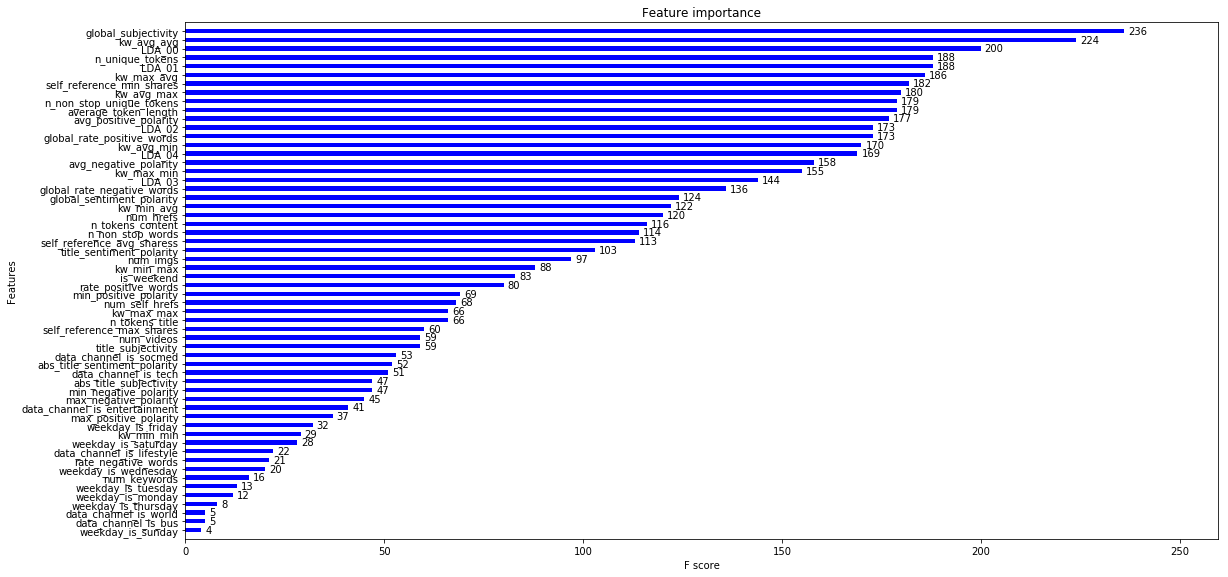

In [27]:
xgb_clf.fit(X_train, y_train)
dtrain = DMatrix(data=X_train, label=y_train, feature_names=X_df.columns)
map1 = {'f{0}'.format(a): b for a, b in enumerate(dtrain.feature_names)}
map_obj = {map1[m]: n for m, n in xgb_clf._Booster.get_score().items()}
_, ax = plt.subplots(figsize=(18.5,9.5))
plot_importance(map_obj, color='blue', height=0.5, ax=ax, grid=False)

### Test data

Next I'll calculate the various accuracy scores achieved by the best classifiers on the test data.

In [41]:
nb_clf = GaussianNB()
nb_clf.fit(X=X_train, y=y_train)
clfs = [knn_clf, svm_clf, rf_clf, ada_clf, xgb_clf, nb_clf]
names = ["KNN", "SVM", "RandomForest", "AdaBoost", "XGBoost", "Naive Bayes"]
for clf, name in zip(clfs, names):
    classifier_score(clf, name, X_test, y_test, "test")


KNN Accuracy score on the test data: 0.6334
KNN Precision score on the test data: 0.6420
KNN Recall score on the test data: 0.5740
KNN F1 score on the test data: 0.6061
KNN AUC of ROC on the test data: 0.6324


SVM Accuracy score on the test data: 0.6418
SVM Precision score on the test data: 0.6375
SVM Recall score on the test data: 0.6284
SVM F1 score on the test data: 0.6329
SVM AUC of ROC on the test data: 0.6416


RandomForest Accuracy score on the test data: 0.6624
RandomForest Precision score on the test data: 0.6585
RandomForest Recall score on the test data: 0.6504
RandomForest F1 score on the test data: 0.6544
RandomForest AUC of ROC on the test data: 0.6622


AdaBoost Accuracy score on the test data: 0.6694
AdaBoost Precision score on the test data: 0.6651
AdaBoost Recall score on the test data: 0.6590
AdaBoost F1 score on the test data: 0.6621
AdaBoost AUC of ROC on the test data: 0.6692


XGBoost Accuracy score on the test data: 0.6657
XGBoost Precision score on the test da

C:\Users\tkauth\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


And here are the various accuracy scores achieved by the neural net.

In [42]:
print_scores(nn_model, callbacks, X_test, y_test, loss_func="binary_crossentropy", optimizer="adam", data_type="test")

Created model and loaded weights from file ./chkpt/chkpt-192.hdf5
 Accuracy score on the test data: 0.6611
 Precision score on the test data: 0.6589
 Recall score on the test data: 0.6434
 F1 score on the test data: 0.6510
 AUC of ROC on the test data: 0.6608




## Conclusion

### Free-Form Visualization

Below are a set of histograms, repeated from above, but this time showing only the top ten features. Each of them shows a notable skewing of the popular and unpopular distributions. When combined, these skewings enable the classifier to make decisions about how to classify a particular sample. If there were no noticeable skewings of the distributions, the classifier's accuracy would be greatly diminished.

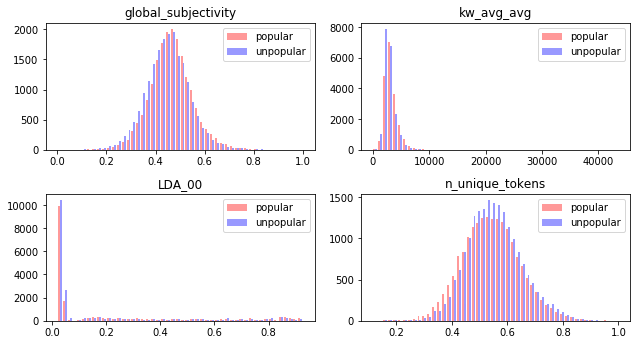

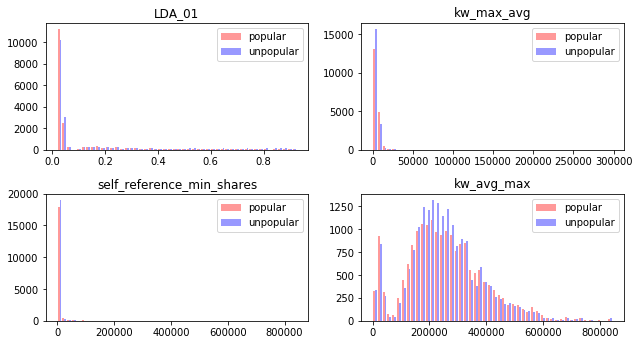

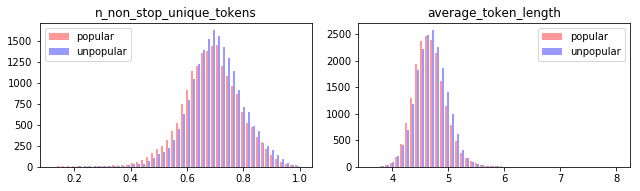

In [29]:
top_ten = [42,25,37,2,38,24,26,22,4,9]

# create the top 10 histograms
for group in splitter(top_ten, 4):
    plot_hist(X_df, y, group)

Below is a scatter plot matrix comparing feature to feature for these ten features. Most of the top ten do not show any significant correlation with other top ten features. This is to be expected. If the features correlated nicely with other features, those features would be largely redundant. So a lack of correlation is what we would expect to see in a set of features that XGBoost regards as the ten most important.

Some correlation is evident between <code>n_unique_tokens</code> and <code>n_non_stop_unique_tokens</code> and also between <code>kw_avg_avg</code> and <code>kw_max_avg</code>. But this is still a relatively small amount of correlation among the top features.

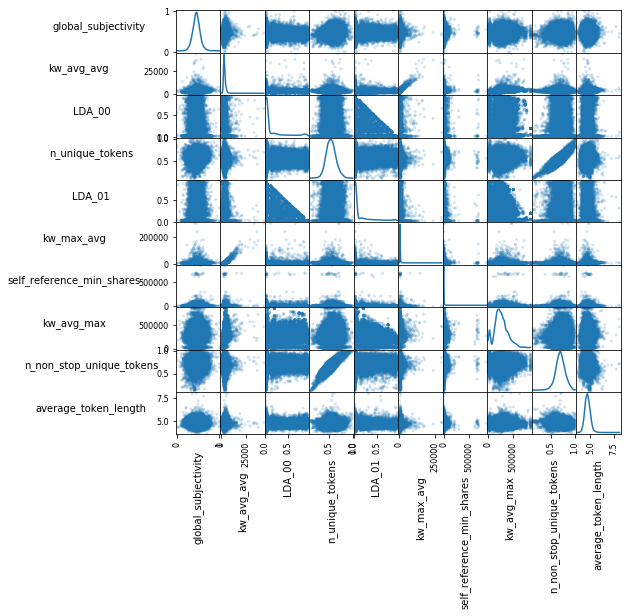

In [30]:
df = pd.DataFrame(X_df.iloc[:,top_ten])

axes = scatter_matrix(df, alpha=0.2, figsize=(9.5, 9.5), diagonal='kde')
for x in range(len(df.columns)):
    for y in range(len(df.columns)):
        axs = axes[x, y]
        axs.xaxis.label.set_rotation(90)
        axs.yaxis.label.set_rotation(0)
        axs.yaxis.labelpad = 65

plt.subplots_adjust(left=0.25, bottom=0.26)